In [1]:
%load_ext lab_black

from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import wavfile
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import serial

Se carga el archivo de audio

In [2]:
base_path = "/tf/notebooks/CEIA/ia-embebida/noise-gate"
assets_path = os.path.join(base_path, "assets")
audios_path = os.path.join(assets_path, "audios")
labels_path = os.path.join(assets_path, "labels")

samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))

data_len = len(data)
duration = data_len / samplerate
print(f"Cantidad de muestras: {data_len}")
print(f"Frecuencia de muestreo: {samplerate} Hz")
print(f"Duracion: {duration:.1f} segundos")
print(f"Valor maximo: {max(data)}")
print(f"Valor minimo: {min(data)}")
print(f"Tipo de dato: {type(data[0])}")

Cantidad de muestras: 956007
Frecuencia de muestreo: 22050 Hz
Duracion: 43.4 segundos
Valor maximo: 32767
Valor minimo: -32768
Tipo de dato: <class 'numpy.int16'>


/tmp/ipykernel_135/2236063515.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))


Graficamos la señal y su fft

In [3]:
timeline = np.linspace(0, duration, num=data_len)

x_freq = fftfreq(data_len, 1 / samplerate)[: data_len // 2]
data_fft = np.abs(fft(data)[0 : data_len // 2])

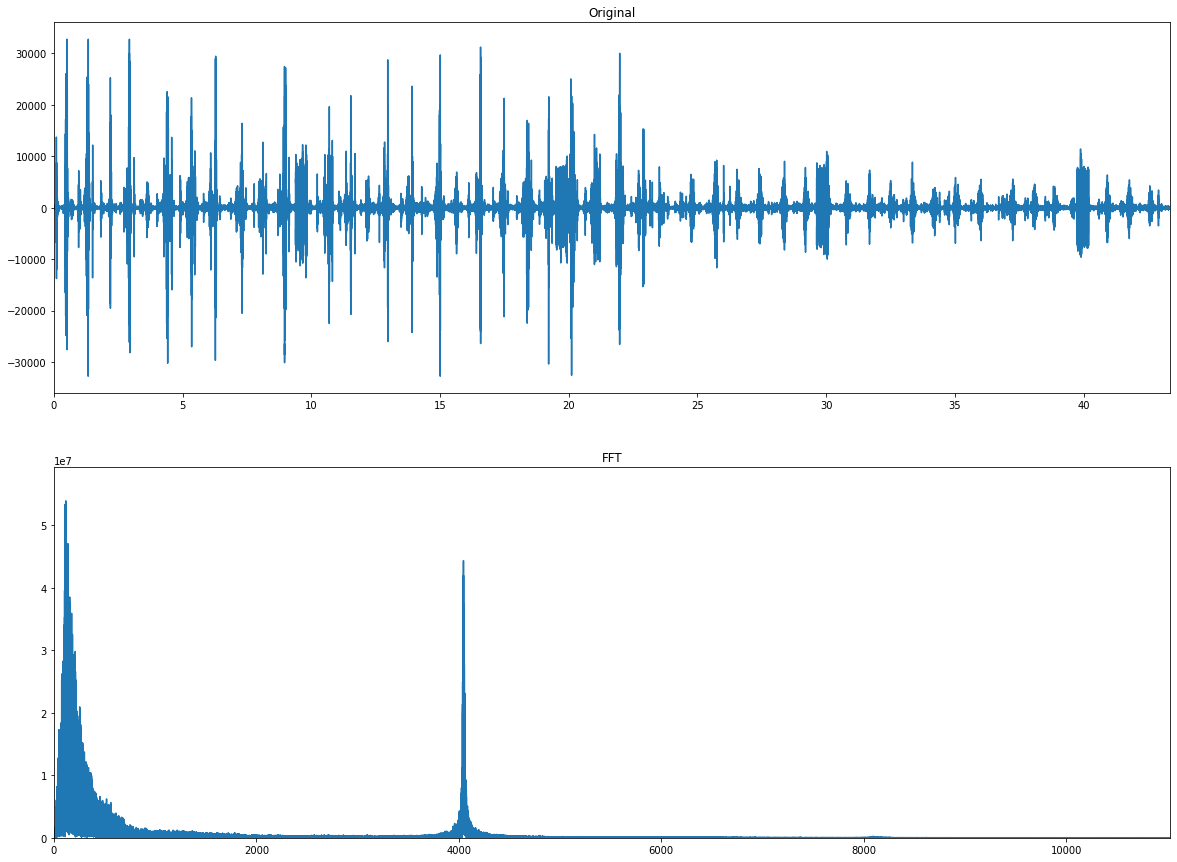

In [4]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(timeline, data)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(x_freq, data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(data_fft) * 1.1])
axes[1].set_title("FFT")

f.show()

Diseñamos un filtro pasa bajo con una banda de paso de hasta 2000Hz y lo aplicamos a nuestra señal

In [5]:
filter_order, wn = signal.buttord(
    wp=2000, ws=3000, gpass=3, gstop=40, analog=False, fs=samplerate
)
b, a = signal.butter(filter_order, wn, "lowpass", analog=False, fs=samplerate)

In [6]:
filtered_data = signal.lfilter(b, a, data)
filtered_data_fft = np.abs(fft(filtered_data)[0 : data_len // 2])

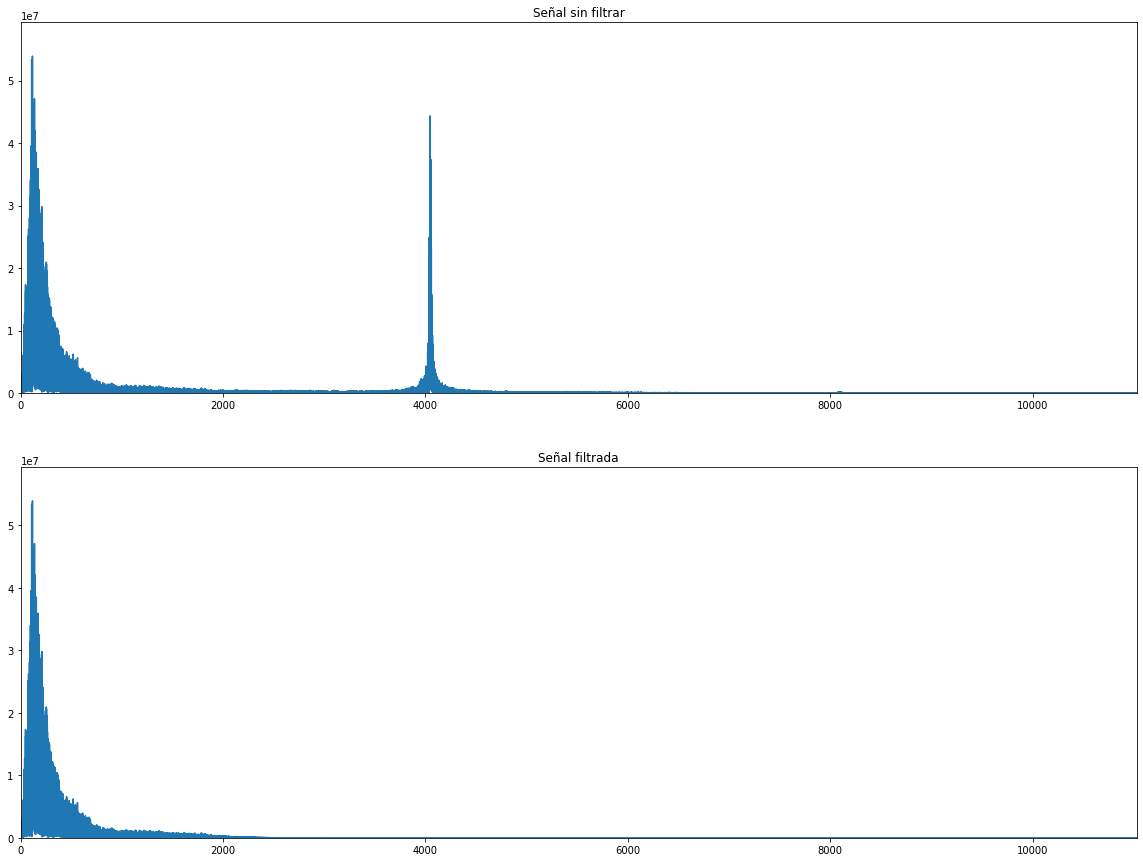

In [7]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(x_freq, data_fft)
axes[0].set_xlim([0, x_freq[-1]])
axes[0].set_ylim([0, max(data_fft) * 1.1])
axes[0].set_title("Señal sin filtrar")

axes[1].plot(x_freq, filtered_data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(data_fft) * 1.1])
axes[1].set_title("Señal filtrada")

f.show()

Hacemos la decimación y reducimos la frecuencia de muestreo 10 veces, es decir a 2.2KHz

In [8]:
dec_data = filtered_data[::10]
dec_timeline = timeline[::10]

dec_samplerate = samplerate / 10
dec_data_len = len(dec_data)
dec_data_fft = np.abs(fft(dec_data)[0 : dec_data_len // 2])
dec_x_freq = fftfreq(dec_data_len, 1 / dec_samplerate)[: dec_data_len // 2]

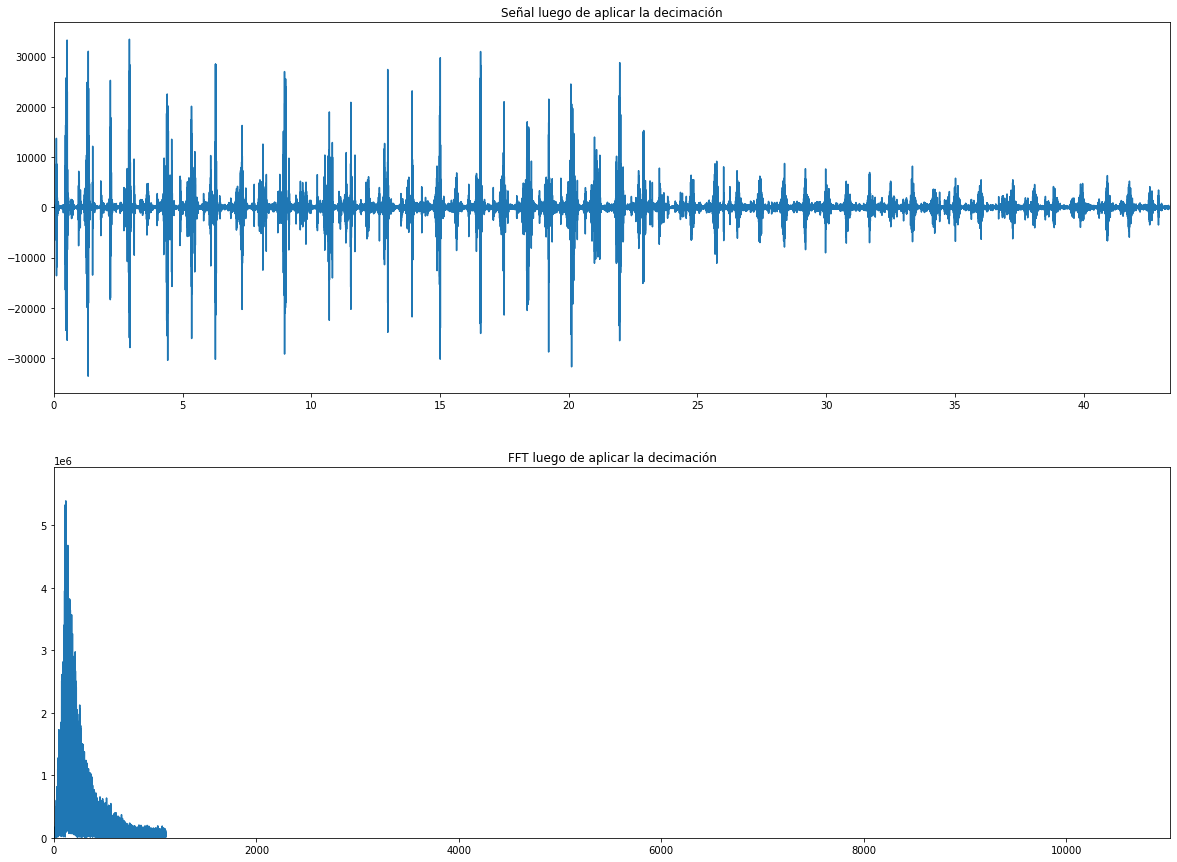

In [9]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, dec_data)
axes[0].set_xlim([0, duration])
axes[0].set_title("Señal luego de aplicar la decimación")

axes[1].plot(dec_x_freq, dec_data_fft)
axes[1].set_xlim([0, x_freq[-1]])
axes[1].set_ylim([0, max(dec_data_fft) * 1.1])
axes[1].set_title("FFT luego de aplicar la decimación")

f.show()

Elevamos los valores al cuadrado

In [10]:
squared_data = dec_data**2

squared_data_fft = np.abs(fft(squared_data)[0 : dec_data_len // 2])

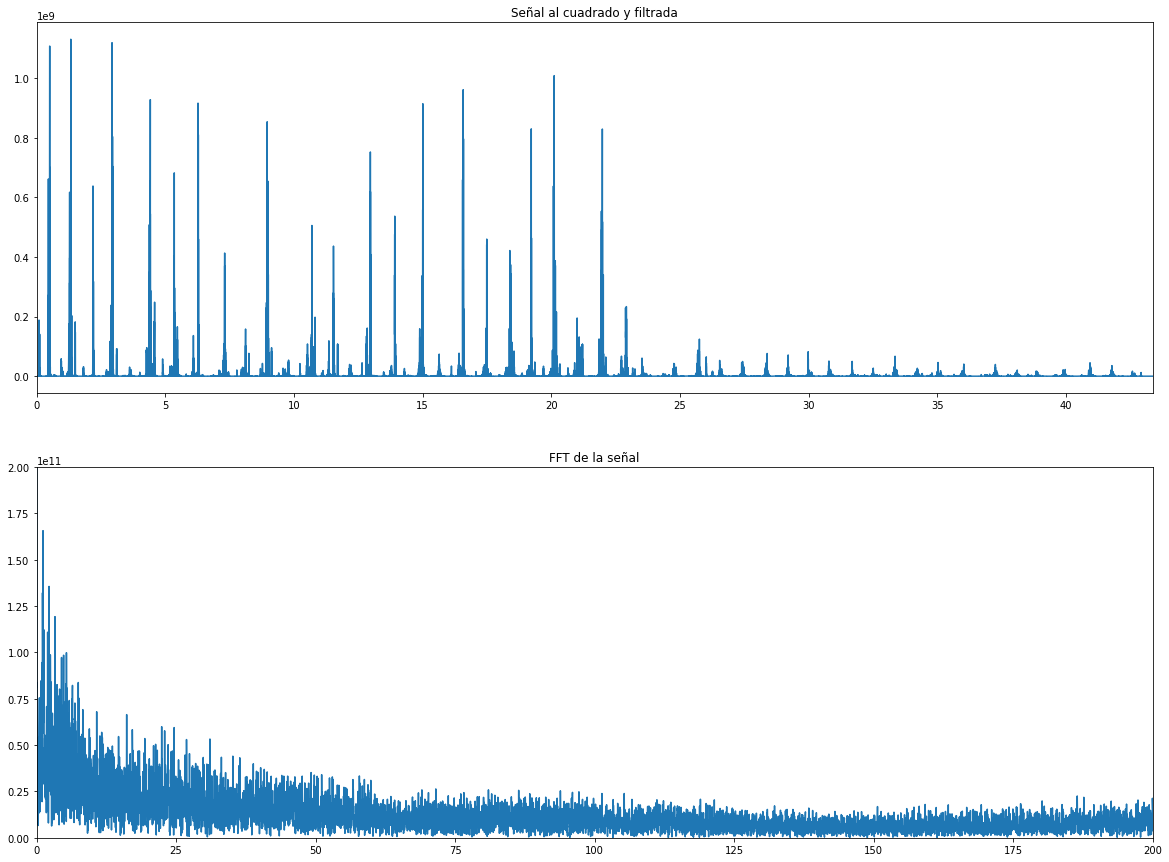

In [11]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, squared_data)
axes[0].set_xlim([0, duration])
axes[0].set_title("Señal al cuadrado y filtrada")

axes[1].plot(dec_x_freq, squared_data_fft)
axes[1].set_xlim([0, 200])
axes[1].set_ylim([0, 2e11])
axes[1].set_title("FFT de la señal")

f.show()

Aplicamos el filtro de media móvil. El tamaño de la ventana para una frecuencia de 50Hz será:

$N = \frac{\sqrt{0.196202 + F_{c}^{2}}}{F_{c}}$, siendo $F_{c} = \frac{f_{c}}{f_{s}} = \frac{50}{2205} = 0,0227$

In [12]:
fc = 50 / 2205
filter_order = round(np.sqrt(0.196202 + fc**2) / fc)
print(f"N = {filter_order}")

N = 20


In [13]:
class SimpleMovingAverage:
    def __init__(self, n):
        self.buffer = collections.deque(maxlen=n)

    def append(self, value):
        self.buffer.append(value)
        return np.sum(self.buffer) / len(self.buffer)


moving_average = SimpleMovingAverage(filter_order)
ma_data = [int(moving_average.append(int(sample))) for sample in squared_data]

ma_data_fft = np.abs(fft(ma_data)[0 : dec_data_len // 2])

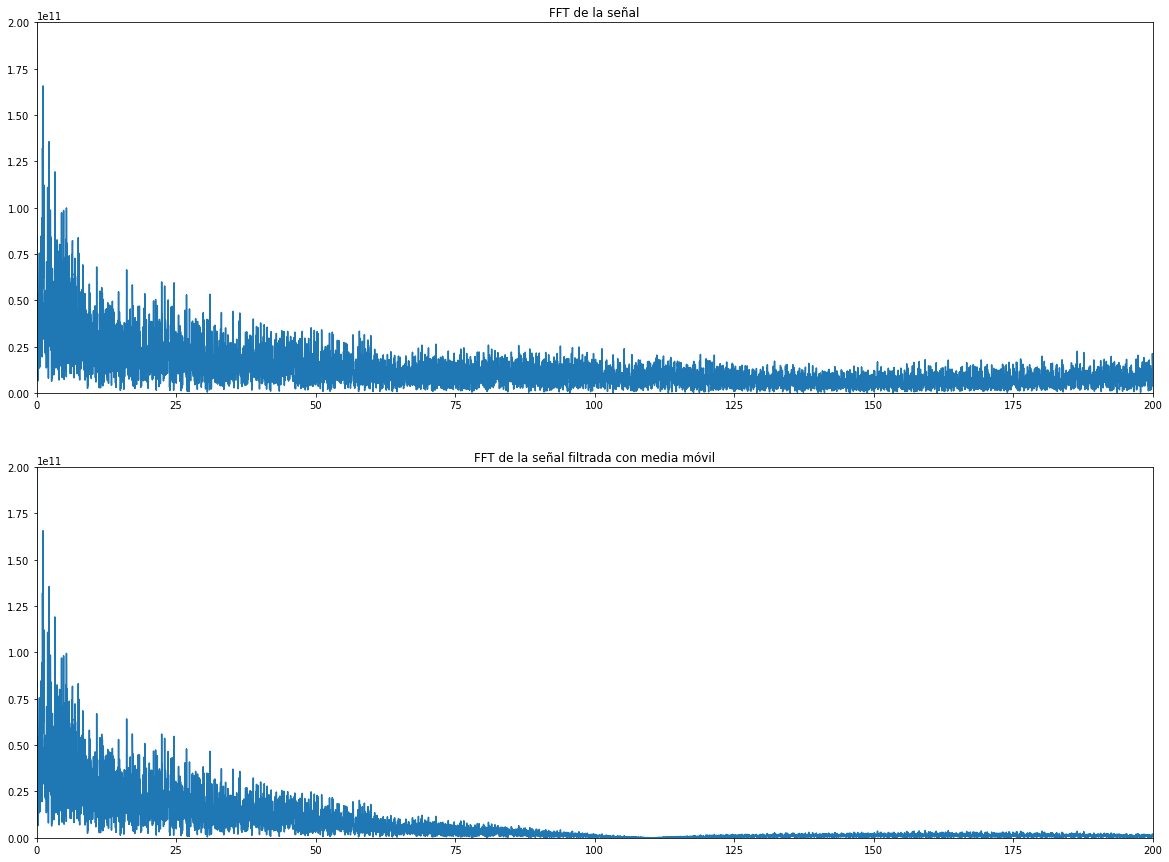

In [14]:
f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_x_freq, squared_data_fft)
axes[0].set_xlim([0, 200])
axes[0].set_ylim([0, 2e11])
axes[0].set_title("FFT de la señal")

axes[1].plot(dec_x_freq, ma_data_fft)
axes[1].set_xlim([0, 200])
axes[1].set_ylim([0, 2e11])
axes[1].set_title("FFT de la señal filtrada con media móvil")

f.show()

Implementamos el filtro de media móvil en el ESP y le pasamos los valores elevados al cuadrado por el puerto serie. El micró devolverá los valores filtrados.

In [46]:
PORT = "/dev/ttyUSB0"
BAUD_RATE = 115200

serial_port = serial.Serial(PORT, BAUD_RATE, timeout=0.25)
serial_port.flushInput()

results_esp = []
for sample in squared_data:
    # for sample in squared_data[:5000]:
    data_uint = int(sample)
    serial_port.write(data_uint.to_bytes(4, "little"))
    bytes = serial_port.read(4)
    result = int.from_bytes(bytes, "little")
    results_esp.append(result)

serial_port.close()

Comprobamos que los resultados filtrados en Python y en el micro sean los mismos.

In [47]:
np.array_equal(ma_data, results_esp)

True

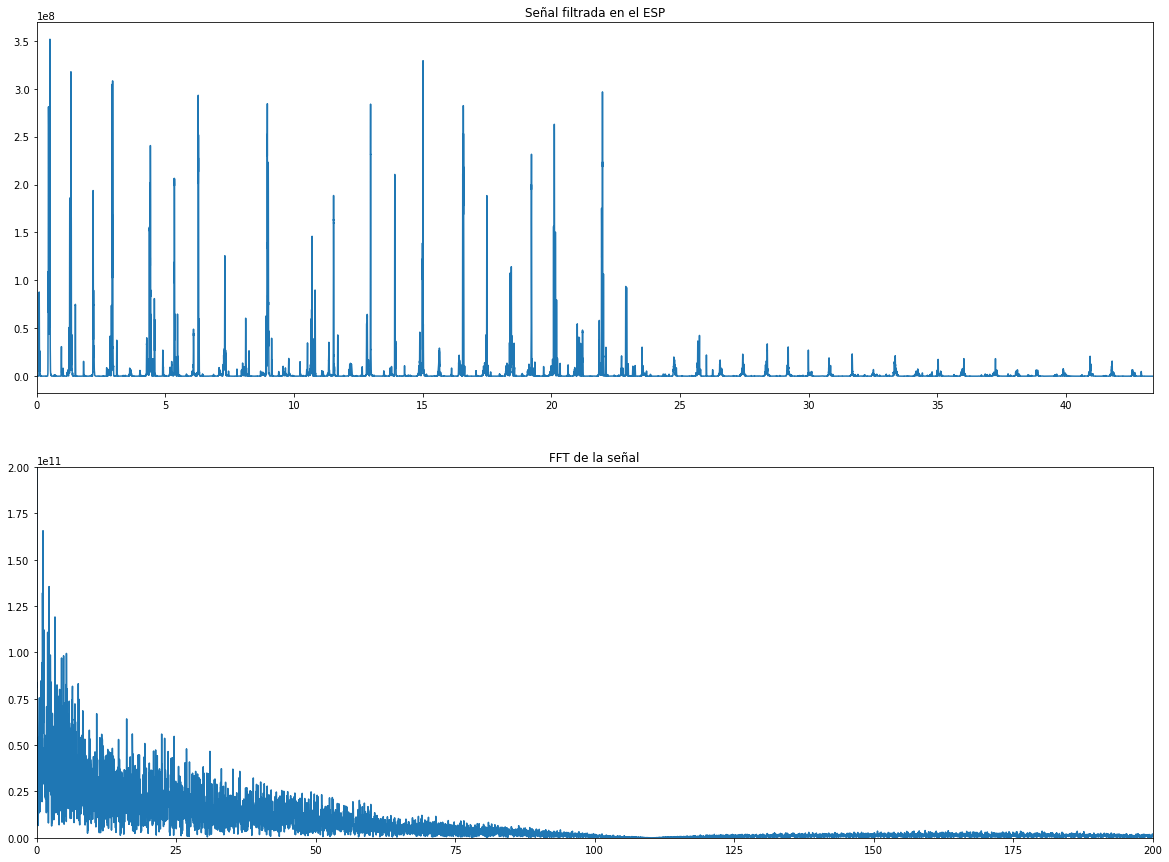

In [54]:
results_esp_fft = np.abs(fft(results_esp)[0 : dec_data_len // 2])

f, axes = plt.subplots(2, figsize=(20, 15))

axes[0].plot(dec_timeline, results_esp)
axes[0].set_xlim([0, duration])
axes[0].set_title("Señal filtrada en el ESP")

axes[1].plot(dec_x_freq, results_esp_fft)
axes[1].set_xlim([0, 200])
axes[1].set_ylim([0, 2e11])
axes[1].set_title("FFT de la señal")

f.show()

Como se puede ver la señal procesada por el micro es igual a la señal procesada por la media móvil en Python. Además podemos ver que el ruido de alta frecuencia se ve atenuado al usar el filtro.